In [1]:
import sys
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import os
import matplotlib.pyplot as plt
import numpy as np
import ot
import time
import numba


from skimage.io import imread,imsave
from skimage.segmentation import slic
from sklearn.cluster import KMeans
import torch
import torch.optim as optim
from skimage.segmentation import slic
import numba 






In [2]:
parent_path='/home/baly/projects/Sliced_opt/code'
sys.path.append(parent_path)
os.chdir(parent_path)
from sopt.library import *
#from sopt.lib_shape import *
from sopt.lib_ot import *   
from sopt.sliced_opt import *  
from sopt.lib_color import *  

/home/baly/projects/Sliced_opt/code/sopt/sliced_opt.py:133: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 2d, A))
  X_theta=np.dot(theta,X.T)
/home/baly/projects/Sliced_opt/code/sopt/sliced_opt.py:163: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  X_theta=np.dot(theta,X.T)


hello


In [4]:
# OT-based color adaptation 
def ot_transfer_32(Xs0,Xt0,Xs,Xt,numItermax=1000000):
    n,d=Xs.shape
    m=Xt.shape[0]
    #plan=ot.emd()
    # get the transporation plan
    Xsc=Xs.copy()
    M=cost_matrix_d_32(Xs,Xt)
    mu=np.ones(n,dtype=np.float32)/n
    nu=np.ones(m,dtype=np.float32)/m
    plan=ot.lp.emd(mu, nu, M, numItermax=numItermax)

    # get the transported Xs
    cond_plan=plan/np.expand_dims(np.sum(plan,1),1)
    Xs=np.dot(cond_plan,Xt)
    
#    # # prediction between images (using out of sample prediction as in [6])
    batch_size=128
    transp_Xs = transform_32(Xs0,Xsc,Xs,batch_size)
    return transp_Xs

@nb.njit(['float32[:,:](float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,int64)'])
def eot_transfer_32(Xs0,Xt0,Xs,Xt,reg=0.1,numItermax=1000000):
    n,d=Xs.shape
    m=Xt.shape[0]
    #plan=ot.emd()
    # get the transporation plan
    Xsc=Xs.copy()
    M=cost_matrix_d_32(Xs,Xt)
    mu=np.ones(n,dtype=np.float32)/n
    nu=np.ones(m,dtype=np.float32)/m
    plan=sinkhorn_knopp_32(mu, nu, M, reg=reg,numItermax=numItermax)

    # get the transported Xs
    cond_plan=plan/np.expand_dims(np.sum(plan,1),1)
    Xs=np.dot(cond_plan,Xt)
    
#    # # prediction between images (using out of sample prediction as in [6])
    batch_size=128
    transp_Xs = transform_32(Xs0,Xsc,Xs,batch_size)
    
    return transp_Xs



/tmp/ipykernel_3274095/103684279.py:36: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, C), array(float32, 2d, A))
  Xs=np.dot(cond_plan,Xt)


exp_num is 0


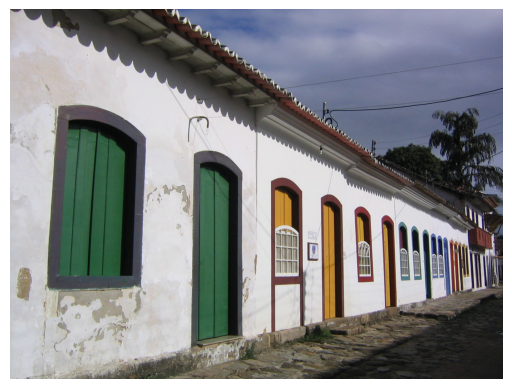

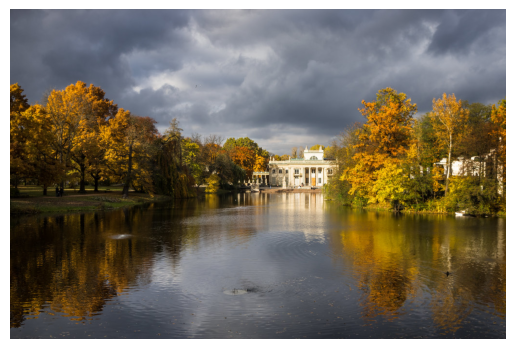

In [5]:
# load the pictures 
exp_num_list=[0,1,2,3,4]
number_list=[(1,1),(3,2),(2,1),(2,3),(3,1)]
exp_num =0
print('exp_num is',exp_num)
s_n,t_n=number_list[exp_num]

data_path='experiment/color_adaption/data/all'
save_path='experiment/color_adaption/results/'+str(exp_num)

I1=imread(data_path+'/source'+str(s_n)+'.jpg').astype(np.float32) / 256
I2=imread(data_path+'/target'+str(t_n)+'.jpg').astype(np.float32) / 256
M1,N1,C=I1.shape
M2,N2,C=I2.shape
Xs0=I1.reshape(-1,C)
Xt0=I2.reshape(-1,C)

N1=5000
N2=10000

plot_image(I1,'source',save_path)
plot_image(I2,'target',save_path)



In [6]:
# load the clustering data
try:
    kmean_Xs=torch.load(data_path+'/kmeans_S'+str(s_n)+'_'+str(N1)+'.pt')
    XsC = kmean_Xs.cluster_centers_
    print('source k-mean')
except:
    rng = np.random.RandomState(42)
    idx1 = rng.randint(Xs0.shape[0], size=(N1,))
    XsC = Xs0[idx1, :]
try:       
    kmean_X2=torch.load(data_path+'/kmeans_T'+str(t_n)+'_'+str(N2)+'.pt')
    XtC = kmean_X2.cluster_centers_
    print('target k-mean')
except:
    rng = np.random.RandomState(40)
    idx2 = rng.randint(X2.shape[0], size=(N2,))
    XtC=X2[idx2,:]
XsC=XsC.astype(np.float32)
XtC=XtC.astype(np.float32)

source k-mean
target k-mean


/home/baly/miniconda3/envs/pot/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KMeans from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
#load time_list
try:
    time_list=torch.load(save_path+'/time_list.pt')
except: 
    time_list={}
print(time_list)

{'spot': 75.97238755226135, 'sopt10.0': 76.88870239257812, 'sopt20.0': 77.13436365127563, 'ot': 46.200533628463745}


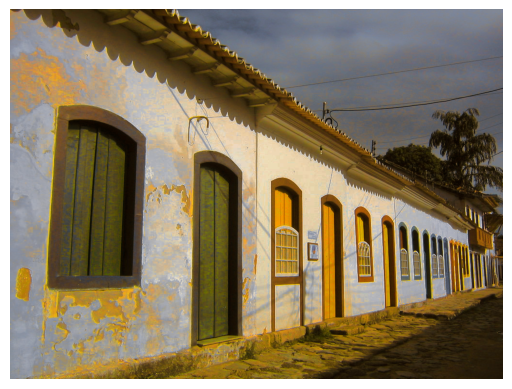

In [9]:
# OT approach
Xs=XsC.copy()
Xt=XtC.copy()
start_time=time.time()
transp_Xs=ot_transfer_32(Xs0,Xt0,Xs,Xt,numItermax=1000000)
end_time=time.time()
wall_time=end_time-start_time 
time_list['ot']=wall_time
recover_image(transp_Xs,I1.shape,'/eot',save_path)
# torch.save(transp_Xs,save_path+'/ot.pt')
torch.save(time_list,save_path+'/time_list.pt')

spot
end


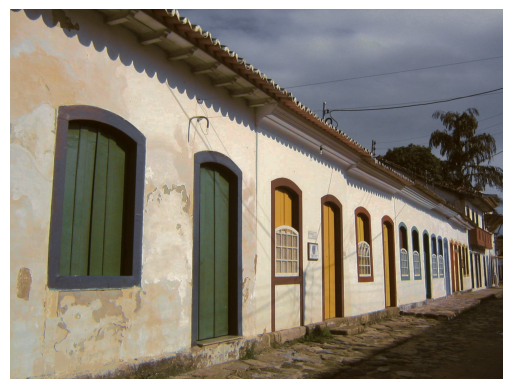

98.1549904346466


In [14]:
# SPOT
Xs=XsC.copy()
Xt=XtC.copy()

print('spot')
n_projections=400
start_time=time.time()
transp_Xs=spot_transfer_32(Xs0,Xt0,Xs,Xt,n_projections)
end_time=time.time()
wall_time=end_time-start_time
time_list['spot']=wall_time 
torch.save(time_list,save_path+'/time_list.pt')
print('end')
recover_image(transp_Xs,I1.shape,'spot',save_path)
print(wall_time)

sopt


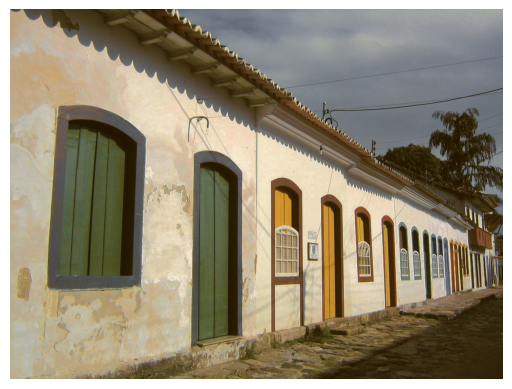

78.63497543334961


In [17]:
# SOPT
print('sopt')
Xs=XsC.copy()
Xt=XtC.copy()

n_projections=400
Lambda=np.float32(10.0)
Lambda_list=np.full((n_projections,),Lambda)
start_time=time.time()
transp_Xs=sopt_transfer_32(Xs0,Xt0,Xs,Xt,Lambda_list,n_projections)
end_time=time.time()
wall_time=end_time-start_time 
time_list['sopt'+str(Lambda)]=wall_time 
recover_image(transp_Xs,I1.shape,'/sopt'+str(Lambda),save_path)
print(wall_time)
torch.save(time_list,save_path+'/time_list.pt')

In [16]:
print('hello')

hello
